## Pasnascope Pipeline

Integrates all of the modules from the package, to go from raw data to csv output.
More information about each module can be found in the other Jupyter Notebooks.
You should change the `experiment name` and the `img_path` at the fist cell.

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

from pasnascope import pipeline, slice_img

experiment_name = '20241211_25C'
root_dir = Path.cwd().parent
project_dir = root_dir.joinpath('data', experiment_name)
res_dir = root_dir.joinpath('results', experiment_name)
res_dir.mkdir(parents=True, exist_ok=True)

# Provide an absolute path for the raw tif image
# If you are starting with an nd2 image, ignore this step and convert the
# image in the next cell
img_path = f'/home/bigbang/ExtraDrive1/20241211_25C.nd2'

If the raw data is in nd2 format, it must first be converted to a tif file, and that tif file should be used in the other cells of this jupyter notebook.

In [4]:
nd2_path = f'/home/bigbang/ExtraDrive1/{experiment_name}.nd2'
# Absolute path where the new tiff file will be saved:
img_path = f'/home/bigbang/ExtraDrive1/pasnascope/{experiment_name}.tif'

first_frames = f'first_frames.tif'
first_frames_path = root_dir.joinpath('results', experiment_name, first_frames)
if first_frames_path.exists():
    print(f'{first_frames_path.stem} already exists.\nPlease choose another path.')
else:
    slice_img.save_first_frames_as_tiff(nd2_path, first_frames_path, 10)

Visualize the regions of the individual embryos that will be cropped.
If the bounding boxes don't fit the embryo, you can try changing the `thres_adjust` parameter at line 1.
The resulting image also shows the number that will be used for each embryo when saving the individual movies.

If after adjust `thres_adjust` the embryos are still not framed as expected, one can use `slice_img.increase_bbox()` to control the bbox dimensions.

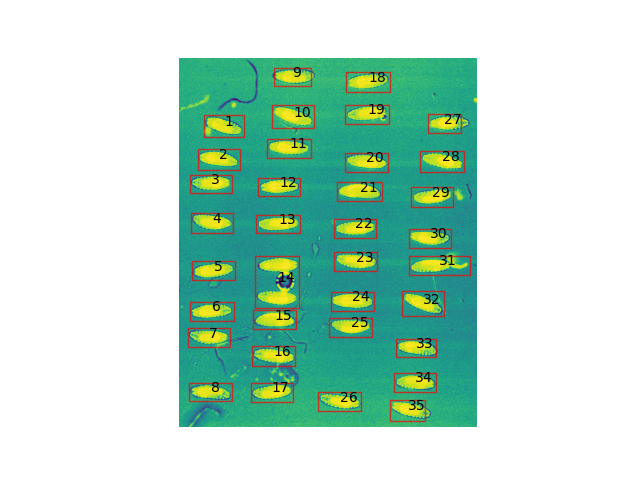

Saved image at /home/bigbang/Documents/repos/pasnascope/results/20241211_25C/emb_numbers.png


In [8]:
img = slice_img.get_first_image_from_mmap(first_frames_path)

coords = slice_img.calculate_slice_coordinates(first_frames_path, n_cols=4, thres_adjust=5)

# If necessary, manually change the bboxes size by changing w and h:
coords = slice_img.increase_bbox(coords, w=25, h=25)

boundaries = coords.values()

rect_coords = [slice_img.boundary_to_rect_coords(b, img.shape) for b in boundaries]
recs = [Rectangle((y,x), w, h) for (x,y,w,h) in rect_coords]

centroids = {i: ((x0+x1)//2, (y0+y1)//2) for i, (x0, x1, y0, y1) in coords.items()}
h = img.shape[0]
w = img.shape[1]

fig, ax = plt.subplots()
fig.canvas.header_visible = False
fig.canvas.resizable = False
ax.set_axis_off()
ax.imshow(img)

for i, (y, x) in centroids.items():
    ax.text(x, y, str(i))

pc = PatchCollection(recs, color='red', alpha=0.7, linewidth=1, facecolor='none')
ax.add_collection(pc)

plt.show()
dest = root_dir.joinpath('results', experiment_name)
dest.mkdir(parents=True, exist_ok=True)
save_path = dest / 'emb_numbers.png'
plt.savefig(save_path)
print(f'Saved image at {save_path}')

If the image above looks good, select which embryos you want to analyze, by changing the values in the `embryos` list in the next cell.
Embryos will be saved under the `data` directory, for the corresponding experiment.

The length and activity data will be saved in the `results` directory.

In [ ]:
# Delete the individual movies created after the end of the analysis
clean_up_data = False
# List of the ids of the embryos that should be processed
embryos = [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 32, 33, 34, 35]
# Interval used to calculate VNC length
vnc_length_interval = 10
# Window to calculate VNC ROI (which is then used to calculate activity)
window = 1

# directories and file paths 
embs_dest = root_dir.joinpath('data', experiment_name, 'embs')
embs_dest.mkdir(parents=True, exist_ok=True)

# nd2 to tiff
print('Converting from nd2 to tif')
slice_img.save_as_tiff(nd2_path, img_path)

# tif to individual movies
print('Cropping individual movies')
slice_img.cut_movies(coords, img_path, embs_dest, embryos=embryos, overwrite=False)

# movies to length
print('Calculating VNC lengths')
num_saved_length_files = pipeline.measure_vnc_length(embs_dest, res_dir, vnc_length_interval)
if num_saved_length_files > 0:
    print(f"Wrote length data for {num_saved_length_files} embryos.")

# movies to full length
print('Calculating embryo full length')
# Change low_non_VNC to True if values in the VNC periphery are very low
low_non_VNC = False
num_full_lengths_measured = pipeline.measure_embryo_full_length(embs_dest, res_dir, low_non_VNC=low_non_VNC)
if num_full_lengths_measured > 0:
    print(f"Wrote full length data for {num_full_lengths_measured} embryos.")

# movies to activity
print('Calculating signal traces')
num_act_calculated = pipeline.calc_activities(embs_dest, res_dir, window)
if num_act_calculated > 0:
    print(f"Wrote activity data for {num_act_calculated} embryos.")

# delete individual movies
if clean_up_data:
    tif_path = Path(img_path)
    pipeline.clean_up_files(embs_dest, first_frames_path, tif_path)
else:
    pipeline.clean_up_files(None, first_frames_path, None)

# write params used
output_path = root_dir.joinpath('results', experiment_name, 'params.txt')
pipeline.log_params(path=output_path, experiment_name=experiment_name,embryos=embryos, window=window, vnc_length_interval=vnc_length_interval, low_non_VNC=low_non_VNC)

Converting from nd2 to tif


{'T': 4200}: 100%|██████████| 4201/4201 [03:30<00:00, 19.95it/s]


Cropping individual movies
Calculating VNC lengths
Wrote length data for 31 embryos.
Calculating embryo full length
Embryo emb21-ch2 full length measurement should be manually checked.
Embryo emb35-ch2 full length measurement should be manually checked.
Wrote full length data for 31 embryos.
Calculating signal traces
Wrote activity data for 31 embryos.
